In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from RSRTxReadBin.RTxReadBin import RTxReadBin

# Signal Processing
from scipy.fft import fft, fftfreq, fftshift
from scipy.fft import rfft, rfftfreq
from scipy.signal import stft


## Learning 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import pickle


In [9]:
## get fmax helper function
def get_f_max(t, my, cutoff = 200e6, zeropad = False, no_dc = True):

    zero_pad_N = 100000

    dt = t[1]-t[0]
    
    N = len(t)
    if zeropad:
        # FFT code
        extra = np.zeros((zero_pad_N))
        mye = np.concatenate((my,extra))
        freq = rfft(mye-np.mean(mye))
        f = rfftfreq(N+zero_pad_N, dt)
    else:
        # FFT code
        freq = rfft(my-np.mean(my))
        f = rfftfreq(N, dt)
    #plt.plot(f,freq)
    
    idx = [i for i,v in enumerate(f) if v > cutoff]

    freq = freq[idx]
    f = f[idx]

    f_max = f[np.argmax(np.abs(freq))]

    #if f_max < 2e9:
    #    plt.plot(f[:50],freq[:50])
    return f_max

## Classifier class and plotting functions
class speechClassifierLab():
    def __init__(self, data_folder, feature_space = 20, cutoff = 200e6, processing = True, ch=0):
        ## Ch=0 == MTJ, Ch=1 == ARB
        files = []
        for f in os.listdir(data_folder):
            if f.endswith("Wfm.bin") and (f.startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9"))):
                files.append(f)
                
        ### Generate smaller dataset for testing ###
        #files = files[::2]
        
        self.feature_space = feature_space
        self.features = np.zeros((len(files), feature_space))
        self.classes = []
                
      
        for n, file in tqdm(enumerate(files), total=len(files)):
            wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
            wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch]))] # Take only first half of the data to remove most of empty part
            t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
            #append class from filename
            self.classes.append(int(file[0]))
        
            for i,(ti,wfmi) in enumerate(zip(np.array_split(t,feature_space), np.array_split(wfm_data,feature_space))):
                self.features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
        
    def clf(self, layers = (10,10)):
        
        # Create a train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        crossval = kf.split(X_train, y_train)

        # Create an MLPClassifier    
        clf = MLPClassifier(hidden_layer_sizes=layers, max_iter=100000, random_state=42,activation="tanh")
        
        # Train the model
        scores = cross_val_score(clf, X_train, y_train, cv=crossval)

        # Make predictions
        predictions = cross_val_predict(clf, X_test, y_test, cv=3)

        # Print accuracy
        test_acc = np.mean(predictions == y_test)
        print("Accuracy on test set:\t\t", test_acc)
        print("Accuracy on training set:\t", scores.mean())
        return test_acc, scores.mean()
    
    def PCA_plot(self, save=False, savepath = "pcs.pdf"):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.features)
        
        colors = ["tab:blue", "tab:orange"]
        # Plot the 2D representation
        #c=list(map(str, self.classes)), label=list(map(str, self.classes)), cmap=matplotlib.colors.ListedColormap(colors)
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=self.classes)
        plt.title(f'2D Projection of {self.feature_space}D Data using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig("pca.pdf")
        plt.legend(*scatter.legend_elements())
        if save:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()


    def tSNE(self, savefig = False, savepath = "tsne.pdf"):
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(self.features)
        scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=self.classes)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(*scatter.legend_elements())
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
    
    def confmat(self, savefig = False, savepath = "confmat.pdf", struct = (10,10)):
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.10, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=struct, max_iter=100000, random_state=42,activation="tanh")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        plt.matshow(cm)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return

In [2]:
wfm_data, b, meta_data = RTxReadBin("waveforms_r6p8_fast/8_george_1.Wfm.bin", nNofChannels=2)
wfm_data.shape

(1333334, 1, 2)

## Master of all sweeps
This goes through combinations of feature_space and cutoff and save them to pickle files. The pickle files hold the class instance, so it should be good to go

In [13]:
wfm_path = "./waveforms_r2p3_fast/"

features =[10, 20, 50, 100, 200, 500]
cutoffs= [40e6, 60e6, 80e6, 100e6, 150e6]

for feat in features:
    for co in cutoffs:
        # create class
        classi = speechClassifierLab(wfm_path, feature_space=feat, cutoff=co, ch=0)
        #dump class instance to pickle for later use 
        with open(f'Pickles/{wfm_path}/features{feat}cutoff{co}.pkl', 'wb') as f:
            pickle.dump(classi, f)

  1%|▏         | 38/2995 [00:24<32:22,  1.52it/s]


KeyboardInterrupt: 

In [22]:
# pickles can be loaded with
feature = 500
cutoff = 80 # MHz
with open(f'Pickles/waveforms_r2p3_fast/features{feature}cutoff{cutoff}.pkl', 'rb') as f:
    f500co80 = pickle.load(f)

### On MTJ

In [3]:
path = "./waveforms_r2p3_fast/"

In [4]:
classi = speechClassifierLab(path, feature_space=500, cutoff=80e6, ch=0)

  0%|          | 0/2995 [00:00<?, ?it/s]

100%|██████████| 2995/2995 [22:27<00:00,  2.22it/s]


In [18]:
feat = 500
co = 80e6
with open(f'Pickles/{wfm_path}/features{feat}cutoff{int(co*1e-6)}.pkl', 'wb') as f:
    pickle.dump(classi_pickled, f)

In [6]:
lay = (20)#(200,500,500, 200)

classi.clf(layers=lay)

Accuracy on test set:		 0.12333333333333334
Accuracy on training set:	 0.09313078211953725


(0.12333333333333334, 0.09313078211953725)

In [8]:
with open('pickle_test.pkl', 'wb') as f:
    pickle.dump(classi, f)

In [14]:
with open('pickle_test.pkl', 'rb') as f:
    classi_pickled = pickle.load(f)

In [15]:
classi_pickled.features

array([[8.12397841e+08, 7.99899413e+08, 7.62404128e+08, ...,
        8.25205683e+08, 8.37708799e+08, 8.37708799e+08],
       [8.12397841e+08, 8.12397841e+08, 8.24896269e+08, ...,
        8.12702566e+08, 8.12702566e+08, 8.12702566e+08],
       [8.12397841e+08, 8.12397841e+08, 8.12397841e+08, ...,
        8.12702566e+08, 8.12702566e+08, 8.00199450e+08],
       ...,
       [7.99899413e+08, 7.99899413e+08, 7.99899413e+08, ...,
        8.12702566e+08, 8.25205683e+08, 8.12702566e+08],
       [8.12397841e+08, 8.12397841e+08, 8.12397841e+08, ...,
        7.75193217e+08, 8.12702566e+08, 7.62690100e+08],
       [7.87400984e+08, 8.12397841e+08, 7.99899413e+08, ...,
        8.25205683e+08, 8.12702566e+08, 8.00199450e+08]])

[[0.2        0.         0.05       0.075      0.         0.15
  0.         0.         0.         0.525     ]
 [0.25714286 0.         0.14285714 0.02857143 0.         0.22857143
  0.         0.         0.         0.34285714]
 [0.38095238 0.         0.14285714 0.04761905 0.         0.19047619
  0.04761905 0.         0.         0.19047619]
 [0.41935484 0.         0.06451613 0.06451613 0.         0.12903226
  0.         0.         0.         0.32258065]
 [0.2        0.         0.3        0.03333333 0.         0.1
  0.         0.         0.         0.36666667]
 [0.2962963  0.         0.07407407 0.11111111 0.         0.25925926
  0.         0.         0.03703704 0.22222222]
 [0.26086957 0.         0.04347826 0.08695652 0.         0.2173913
  0.         0.         0.04347826 0.34782609]
 [0.10344828 0.03448276 0.20689655 0.06896552 0.         0.20689655
  0.         0.         0.03448276 0.34482759]
 [0.16129032 0.03225806 0.19354839 0.         0.         0.25806452
  0.         0.         0.

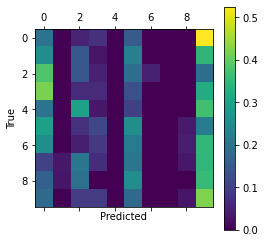

In [27]:
classi.confmat(struct=lay)

(0.0, 10.0)

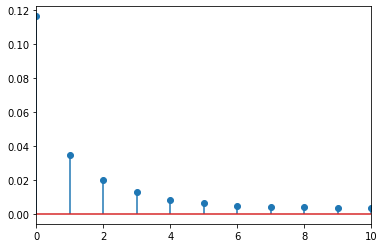

In [40]:
p_c_a = PCA()

p_c_a.fit(classi.features)
plt.stem(p_c_a.explained_variance_ratio_)
plt.xlim([0,10])

In [55]:
res = classi.clf(layers=(10))

Accuracy on test set:		 0.13333333333333333
Accuracy on training set:	 0.14174497276112286


### On ARB

In [56]:
classiarb = speechClassifierLab(path, feature_space=20, cutoff=100e6, ch=1)

  0%|          | 0/2995 [00:00<?, ?it/s]

100%|██████████| 2995/2995 [10:16<00:00,  4.86it/s]


In [58]:
resarb = classiarb.clf(layers=(10))

Accuracy on test set:		 0.09333333333333334
Accuracy on training set:	 0.1436026005963898


## Binary classification

In [10]:
## Classifier class and plotting functions
class speechClassifierBinary():
    def __init__(self, data_folder, feature_space = 20, cutoff = 100e6, processing = True, ch=0):
        ## Ch=0 == MTJ, Ch=1 == ARB
        files = []
        for f in os.listdir(data_folder):
            if f.endswith("Wfm.bin") and (f.startswith(("0", "1"))):
                files.append(f)
                
        ### Generate smaller dataset for testing ###
        #files = files[::2]
        
        self.feature_space = feature_space
        self.features = np.zeros((len(files), feature_space))
        self.classes = []
                
      
        for n, file in tqdm(enumerate(files), total=len(files)):
            wfm_data, b, meta_data = RTxReadBin(data_folder+file, nNofChannels=2)
            wfm_data  = np.array(wfm_data[:,0,ch])[:int(len(wfm_data[:,0,ch]))] # Take only first half of the data to remove most of empty part
            t = np.linspace(0, len(wfm_data)*meta_data["Resolution"], len(wfm_data))
            #append class from filename
            self.classes.append(int(file[0]))
        
            for i,(ti,wfmi) in enumerate(zip(np.array_split(t,feature_space), np.array_split(wfm_data,feature_space))):
                self.features[n,i] = get_f_max(ti, wfmi, cutoff=cutoff)
        
    def clf(self, layers = (10,10)):
        
        # Create a train-test split
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.20, random_state=42)
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        crossval = kf.split(X_train, y_train)

        # Create an MLPClassifier    
        clf = MLPClassifier(hidden_layer_sizes=layers, max_iter=100000, random_state=42,activation="tanh")
        
        # Train the model
        scores = cross_val_score(clf, X_train, y_train, cv=crossval)

        # Make predictions
        predictions = cross_val_predict(clf, X_test, y_test, cv=3)

        # Print accuracy
        test_acc = np.mean(predictions == y_test)
        print("Accuracy on test set:\t\t", test_acc)
        print("Accuracy on training set:\t", scores.mean())
        return test_acc, scores.mean()
    
    def PCA_plot(self, save=False, savepath = "pcs.pdf"):
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(self.features)
        
        colors = ["tab:blue", "tab:orange"]
        # Plot the 2D representation
        #c=list(map(str, self.classes)), label=list(map(str, self.classes)), cmap=matplotlib.colors.ListedColormap(colors)
        scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=self.classes)
        plt.title(f'2D Projection of {self.feature_space}D Data using PCA')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        #plt.savefig("pca.pdf")
        plt.legend(*scatter.legend_elements())
        if save:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()


    def tSNE(self, savefig = False, savepath = "tsne.pdf"):
        X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=30).fit_transform(self.features)
        scatter = plt.scatter(X_embedded[:,0],X_embedded[:,1],c=self.classes)
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.legend(*scatter.legend_elements())
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
    
    def confmat(self, savefig = False, savepath = "confmat.pdf", struct = (10,10)):
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.classes, test_size=0.20, random_state=42)
        clf = MLPClassifier(hidden_layer_sizes=struct, max_iter=100000, random_state=42,activation="tanh")
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        cm = cm/cm.sum(axis=1)[:, np.newaxis]
        print(cm)
        plt.matshow(cm)
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        if savefig:
            print("figure saved")
            plt.tight_layout()
            plt.savefig(savepath)
        plt.show()
        return
        

In [11]:
binaryboy = speechClassifierBinary("./waveforms_600nmp1/", feature_space=50, cutoff=100e6, ch=0)

  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 600/600 [03:43<00:00,  2.68it/s]


In [12]:
binres = binaryboy.clf(layers=(20,20))

Accuracy on test set:		 0.725
Accuracy on training set:	 0.7104166666666667


[[0.58064516 0.41935484]
 [0.17241379 0.82758621]]


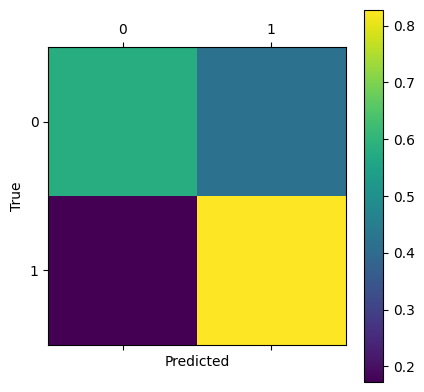

In [106]:
binaryboy.confmat(struct=(20,10))

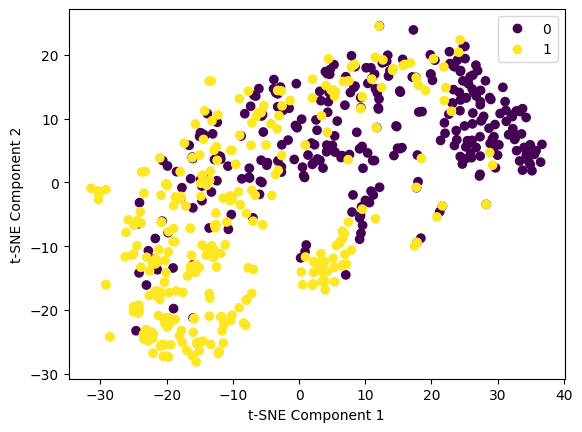

In [107]:
binaryboy.tSNE()

## Count parameters

In [27]:
from sklearn.neural_network import MLPClassifier
import numpy as np

# Define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=100000, random_state=42, activation="tanh")

# Create example data (ensure this matches the expected dimensions of your problem)
X_train = np.random.rand(100, 20)  # Example feature data with 100 samples and 20 features
y_train = np.random.randint(0, 2, 100)  # Example binary labels

# Fit the model
mlp.fit(X_train, y_train)

# Function to calculate the number of trainable parameters
def count_trainable_parameters(mlp):
    # Ensure the model has been fitted
    if hasattr(mlp, 'coefs_') and hasattr(mlp, 'intercepts_'):
        total_params = 0
        # Add parameters from weights (coefs_)
        for coef in mlp.coefs_:
            total_params += np.prod(coef.shape)
        # Add parameters from biases (intercepts_)
        for intercept in mlp.intercepts_:
            total_params += np.prod(intercept.shape)
        return total_params
    else:
        raise ValueError("The model has not been fitted yet. Please call the fit method before accessing trainable parameters.")

# Get the number of trainable parameters
num_params = count_trainable_parameters(mlp)
print(f'The number of trainable parameters in the MLP is: {num_params}')


The number of trainable parameters in the MLP is: 641


In [24]:
(20*20+10)+(20*10+10)+(10*10+10)

730